In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import date 
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
pd.options.display.max_columns = 600

df=pd.read_csv('airbnb_data_cleaned.csv')

In [ ]:
df.head()

ml_df is the dataframe with all the features that have been engineered. While df is the original dataframe. We will use ml_df for the eventural ml algorithms.

In [15]:
# Adding the first 5 columns with 0/1 features indicating whether the information was not provided/provided
ml_df = df[['neighborhood_overview','transit','access','interaction','house_rules']]

host ID - separate into bins (0-50 , 50-100, >100)

In [16]:
host_id = df[['host_id']]
host_id['count']=host_id.groupby(['host_id'])['host_id'].transform('count')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
def lists_binning(count):
    if count >100:
        return 'greater than 100'
    elif count <50:
        return 'less than 50'
    else:
        return '>50 and <100'

In [18]:
host_id['list_bins']=host_id['count'].apply(lists_binning)

listing_onehot_features = pd.get_dummies(host_id['list_bins'])
ml_df=pd.concat([ml_df, listing_onehot_features], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We will use the year-month format to create a column and get dummies for that and include in ml_df. we will ignore the day.

In [19]:
host_since=pd.to_datetime(df['host_since'], format='%Y-%m-%d')
host_since=host_since.to_frame()
host_since['host_since_ym']=host_since['host_since'].apply(lambda x: (str(x.year)+'-'+str(x.month)))

ym_onehot_features = pd.get_dummies(host_since['host_since_ym'])

ml_df=pd.concat([ml_df, ym_onehot_features], axis=1)

Host location - encode for categorical
Host response time - encode for categorical

In [20]:
location_onehot_features = pd.get_dummies(df['host_location'])
ml_df=pd.concat([ml_df, location_onehot_features], axis=1)

responsetime_onehot_features = pd.get_dummies(df['host_response_time'])
ml_df=pd.concat([ml_df, responsetime_onehot_features], axis=1)

We will scale the host response rate on a scale of 100 and include that column in ml_df

In [21]:
response=df[['host_response_rate']]
response['host_response_rate_100'] = np.array(np.round((response['host_response_rate'] * 100)), dtype='int')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


adding the host response rate scales to 100 and the other two columns with numerical values.

In [22]:
ml_df = pd.concat([ml_df, response.host_response_rate_100, df.host_is_superhost,df.host_total_listings_count], axis=1)

host verifications - # of verifications
count of verifications included in ml_df

In [23]:
verifications=df[['host_verifications']]
verifications['verification_count'] = verifications.host_verifications.map(lambda x: [i.strip() for i in x.split(",")])
verifications['verification_count'] = verifications.verification_count.apply(len)

ml_df = pd.concat([ml_df, verifications.verification_count], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
ml_df= pd.concat([ml_df, df.host_has_profile_pic, df.host_identity_verified], axis=1)

neighborhood cleansed - encode for categorical
neighborhood group cleansed - encode for categorical

In [25]:
nc_onehot_features = pd.get_dummies(df['neighbourhood_cleansed'])

ngc_onehot_features = pd.get_dummies(df['neighbourhood_group_cleansed'])

ml_df=pd.concat([ml_df, nc_onehot_features ,ngc_onehot_features], axis=1)

In [26]:
ml_df= pd.concat([ml_df, df.zipcode, df.latitude, df.longitude, df.is_location_exact], axis=1)

property type - encode for categorical
room type- encode for categorical
bed type - encode for categorical

In [27]:
pt_onehot_features = pd.get_dummies(df['property_type'])

rt_onehot_features = pd.get_dummies(df['room_type'])

ml_df = pd.concat([ml_df, pt_onehot_features ,rt_onehot_features], axis=1)

In [28]:
ml_df=pd.concat([ml_df,df.accommodates,df.bathrooms,df.bedrooms,df.beds],axis=1)

bed type - one hot encoding

In [29]:
bedt_onehot_features = pd.get_dummies(df['bed_type'])

ml_df = pd.concat([ml_df, bedt_onehot_features], axis=1)

amenities- # of amenitite

In [30]:
amenities=df[['amenities']]
amenities['amenity_count'] = amenities.amenities.map(lambda x: [i.strip() for i in x.split(",")])
amenities['amenity_count'] = amenities.amenity_count.apply(len)

ml_df = pd.concat([ml_df, amenities.amenity_count], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
ml_df= pd.concat([ml_df, df.security_deposit, df.cleaning_fee, df.guests_included, df.extra_people,
                 df.minimum_nights, df.maximum_nights],axis=1)

calender updated - encode for categorical
cancellation policy - encode for categorical

In [32]:
calendar_onehot_features = pd.get_dummies(df['calendar_updated'])

ml_df = pd.concat([ml_df, calendar_onehot_features], axis=1)

In [33]:
ml_df = pd.concat([ml_df, df.availability_30, df.availability_60, df.availability_90, df.availability_365,
                  df.number_of_reviews, df.review_scores_rating], axis=1)

all review scores scaled to 100 instead of 10 and added to ml_df

In [34]:
reviews = df[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value']]  
def multiply_10(x):
    return x*10
reviews = reviews.apply(multiply_10)

In [35]:
ml_df = pd.concat([ml_df, reviews, df.instant_bookable],axis=1)

In [36]:
cancel_onehot_features = pd.get_dummies(df['cancellation_policy'])

ml_df = pd.concat([ml_df, cancel_onehot_features], axis=1)

In [37]:
ml_df=pd.concat([ml_df, df.require_guest_profile_picture, df.require_guest_phone_verification], axis=1)

scale reviews per month to 100

In [38]:
df.reviews_per_month.describe()

count    48353.000000
mean         1.140344
std          1.605117
min          0.000000
25%          0.050000
50%          0.410000
75%          1.670000
max         20.330000
Name: reviews_per_month, dtype: float64

In [39]:
rpm=df[['reviews_per_month']]
max_rpm = float(max(rpm.values))

In [40]:
def scale_to_100(x):
    scaled= x/max_rpm *100
    scaled = round(scaled, 2)
    return scaled

In [41]:
rpm = rpm.apply(scale_to_100)

ml_df = pd.concat([ml_df, rpm],axis=1)

In [42]:
price = df[['price']]
ml_df = pd.concat([ml_df, price],axis=1)

In [ ]:
ml_df.head()

In [ ]:
ml_df.shape

* saving the dataframe with feature engineering.

In [ ]:
ml_df.to_csv('ML_df_all_features.csv',index=False) 

**Making new dataframe with NLP features**

In [ ]:
def text_preprocess(input_str):
    input_str = input_str.lower()    # convert text to lowercase
    input_str = re.sub(r'\d+', '', input_str)    # remove numbers
    translator = str.maketrans('', '', string.punctuation)   # remove punctuations
    input_str = (input_str.translate(translator))
    input_str = re.sub(r'[^a-zA-Z\s]', '', input_str, re.I|re.A)    #remove special characters
    input_str = input_str.strip()    # remove white space
    return input_str

StopWords = stopwords.words("english")
def remove_stopwords(input_str):
    input_str = ' '.join([word for word in input_str.split() if word not in StopWords])
    return input_str

nlp = spacy.load('en_core_web_sm')
def lemmatize_text(input_str):
    input_str = nlp(input_str)
    input_str = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in input_str])
    return input_str

In [ ]:
text = df[['name_describe_host']]
text['name_describe_host']=text['name_describe_host'].apply(text_preprocess)
text['name_describe_host']=text['name_describe_host'].apply(remove_stopwords)
text['name_describe_host']=text['name_describe_host'].apply(lemmatize_text)

In [ ]:
text.head()

In [ ]:
cv = CountVectorizer(min_df=0.05, max_df=0.95)
cv_matrix = cv.fit_transform(text.name_describe_host)
cv_matrix = cv_matrix.toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
bag_of_words=pd.DataFrame(cv_matrix, columns=vocab)

In [ ]:
bag_of_words.shape

In [ ]:
bag_of_words.head()

In [ ]:
bag_of_words.to_csv('nlp_df.csv',index=False) 

Dataframe with less columns (no dates, neighbourhood, property type, calender updated

In [43]:
ml_df_less = pd.concat([df.neighborhood_overview, df.transit, df.access, df.interaction, df.house_rules,
                       listing_onehot_features, location_onehot_features,responsetime_onehot_features,
                       response.host_response_rate_100, df.host_is_superhost,df.host_total_listings_count,
                       verifications.verification_count, df.host_has_profile_pic, df.host_identity_verified,
                       ngc_onehot_features,df.zipcode, df.latitude, df.longitude, df.is_location_exact,
                       rt_onehot_features,df.accommodates,df.bathrooms,df.bedrooms,df.beds,bedt_onehot_features,
                       amenities.amenity_count, df.security_deposit, df.cleaning_fee, df.guests_included, 
                       df.extra_people, df.minimum_nights, df.maximum_nights, df.availability_30, df.availability_60, 
                       df.availability_90, df.availability_365, df.number_of_reviews, df.review_scores_rating, 
                       reviews, df.instant_bookable, df.require_guest_profile_picture, 
                       df.require_guest_phone_verification, rpm, price], axis=1)

In [44]:
ml_df_less.shape

(48353, 68)

******

In [3]:
ml_df=pd.read_csv('ML_df_all_features.csv')

In [4]:
nlp_df= pd.read_csv('nlp_df.csv')

ml_nlp_df = pd.concat([ml_df, nlp_df], axis=1)

removing price outliers

In [5]:
q = ml_df["price"].quantile(0.90)
ml_df_o = ml_df[ml_df["price"] < q]
#ml_nlp_df_o = ml_nlp_df[ml_nlp_df['price'] < q]

**Run all models without NLP**

In [6]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
    return (X_train, X_test, y_train, y_test)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor 
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

def run_models(X_train, X_test, y_train, y_test):
    scores ={}
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    scores['linear_regression']={'train':lm.score(X_train, y_train), 'test':lm.score(X_test, y_test)}

    decision_tree = tree.DecisionTreeRegressor(max_features='sqrt', min_impurity_decrease=0.5)
    tree_model = decision_tree.fit(X_train, y_train)
    scores['decision_tree']={'train':tree_model.score(X_train, y_train), 'test':tree_model.score(X_test, y_test)}

    random_forest = RandomForestRegressor(n_estimators=50, max_features='sqrt')
    rf_model = random_forest.fit(X_train, y_train)
    scores['random_forest']={'train':rf_model.score(X_train, y_train), 'test':rf_model.score(X_test, y_test)}

    gradient_boost = GradientBoostingRegressor()
    gb_model = gradient_boost.fit(X_train, y_train)
    scores['gradient_boost']={'train':gb_model.score(X_train, y_train), 'test':gb_model.score(X_test, y_test)}

    ada_boost = AdaBoostRegressor()
    ada_model = ada_boost.fit(X_train, y_train)
    scores['adaboost']={'train':ada_model.score(X_train, y_train), 'test':ada_model.score(X_test, y_test)}

    knn = KNeighborsRegressor()
    knn_model = knn.fit(X_train, y_train)
    scores['KNN']={'train':knn_model.score(X_train, y_train), 'test':knn_model.score(X_test, y_test)}

    xg_reg = xgb.XGBRegressor(objective ='reg:linear')
    xg_reg.fit(X_train,y_train)
    scores['XGboost']={'train':xg_reg.score(X_train, y_train), 'test':xg_reg.score(X_test, y_test)}

    cat_boost=CatBoostRegressor(iterations=50,loss_function='RMSE')
    cat_boost.fit(X_train, y_train, verbose=False)
    scores['catboost']={'train':(cat_boost.score(X_train, y_train))/100, 'test':(cat_boost.score(X_test, y_test))/100}
    
    return scores

In [72]:
ml_df_o_noprice = ml_df_o.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_df_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_o_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_df_o_noprice, ml_df_o.price)


In [73]:
model_scores = run_models(X_train, X_test, y_train, y_test)

In [74]:
model_scores

{'linear_regression': {'train': 0.6494271315730508,
  'test': 0.6418396228055516},
 'decision_tree': {'train': 0.4506144182725007, 'test': 0.4227391108273802},
 'random_forest': {'train': 0.9508714883875695, 'test': 0.6689410829018083},
 'gradient_boost': {'train': 0.6799078804090641, 'test': 0.6753780413052171},
 'adaboost': {'train': 0.375644696382188, 'test': 0.3613446597296637},
 'KNN': {'train': 0.5202360140372473, 'test': 0.291430791412678},
 'XGboost': {'train': 0.6789886430547732, 'test': 0.6752471318648172},
 'catboost': {'train': 0.48102526610099244, 'test': 0.4734840025315867}}

In [164]:
models = pd.DataFrame(model_scores)
models = models.T
models.sort_values(['test'], ascending=False, inplace=True)
models

,test,train
gradient_boost,0.675378,0.679908
XGboost,0.675247,0.678989
random_forest,0.668941,0.950871
linear_regression,0.641840,0.649427
catboost,0.473484,0.481025
decision_tree,0.422739,0.450614
adaboost,0.361345,0.375645
KNN,0.291431,0.520236


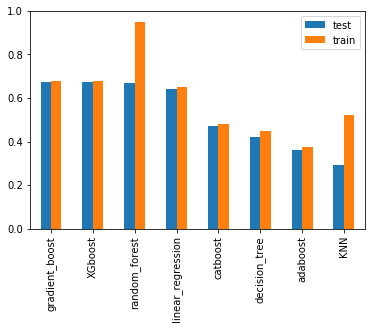

In [165]:
models.plot(kind='bar')

### **All features with NLP**

In [8]:
ml_nlp_df_o = ml_nlp_df[ml_nlp_df['price'] < q]

In [9]:
ml_nlp_df_o = ml_nlp_df_o.loc[:, ~ml_nlp_df_o.columns.duplicated()]

In [87]:
ml_nlp_df_o_noprice = ml_nlp_df_o.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_nlp_df_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_nlp_df_o_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_nlp_df_o_noprice, ml_nlp_df_o.price)

In [88]:
model_scores_nlp = run_models(X_train, X_test, y_train, y_test)

In [161]:
models_nlp = pd.DataFrame(model_scores_nlp)
models_nlp = models_nlp.T
models_nlp.sort_values(['test'], ascending=False, inplace=True)
models_nlp

,test,train
gradient_boost,0.678475,0.683717
XGboost,0.677493,0.682464
linear_regression,0.655106,0.669769
random_forest,0.651645,0.948453
catboost,0.474151,0.481707
decision_tree,0.425854,0.500066
KNN,0.293304,0.520328
adaboost,0.253019,0.274558


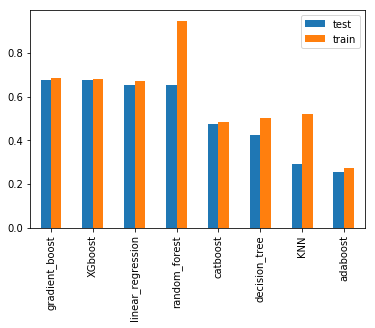

In [162]:
models_nlp.plot(kind='bar')

*********
********

## **ml_df_less - without neighborhood, host joined date, property type, calender updated - because those columns had many unique values - increased the number of features drastically**

In [91]:
ml_df_less.shape

(48353, 68)

In [92]:
q = ml_df_less["price"].quantile(0.90)
ml_df_less_o = ml_df_less[ml_df_less["price"] < q]     #remove outlier price rows

In [93]:
ml_df_less_o_noprice = ml_df_less_o.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_df_less_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_less_o_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_df_less_o_noprice, ml_df_less_o.price)


In [94]:
model_scores_less = run_models(X_train, X_test, y_train, y_test)

In [159]:
models_less = pd.DataFrame(model_scores_less)
models_less = models_less.T
models_less.sort_values(['test'], ascending=False, inplace=True)
models_less

,test,train
random_forest,0.680393,0.952464
gradient_boost,0.674658,0.678718
XGboost,0.673583,0.677976
decision_tree,0.583713,0.619851
linear_regression,0.582592,0.584087
catboost,0.466215,0.473564
adaboost,0.407630,0.419225
KNN,0.290944,0.520378


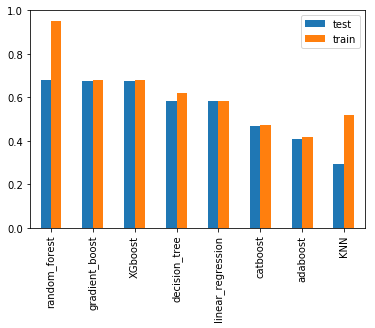

In [160]:
models_less.plot(kind='bar')

******
##  Removing features with low variance

In [77]:
from sklearn.feature_selection import VarianceThreshold

X = ml_df_o_noprice

sel = VarianceThreshold(threshold=(0.5))
X_new = sel.fit_transform(X)

X_train, X_test, y_train, y_test = split_data(X_new, ml_df_o.price)

In [78]:
model_scores_low_variance = run_models(X_train, X_test, y_train, y_test)

In [157]:
models_low_variance = pd.DataFrame(model_scores_low_variance)
models_low_variance = models_low_variance.T
models_low_variance.sort_values(['test'], ascending=False, inplace=True)
models_low_variance

,test,train
XGboost,0.591122,0.591372
random_forest,0.590205,0.938842
gradient_boost,0.587366,0.589188
catboost,0.492851,0.504495
decision_tree,0.439939,0.497894
linear_regression,0.383727,0.369767
adaboost,0.304699,0.317357
KNN,0.288134,0.517621


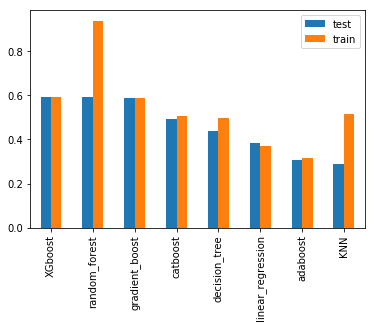

In [158]:
models_low_variance.plot(kind='bar')

******
******
##  Select from Model

In [81]:
from sklearn.feature_selection import SelectFromModel

X = ml_df_o_noprice
y = ml_df_o.price

model = GradientBoostingRegressor()

sfm = SelectFromModel(model, max_features=150)
X_new = sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = split_data(X_new, y)

In [82]:
model_scores_sfm = run_models(X_train, X_test, y_train, y_test)

In [155]:
models_sfm = pd.DataFrame(model_scores_sfm)
models_sfm = models_sfm.T
models_sfm.sort_values(['test'], ascending=False, inplace=True)
models_sfm

,test,train
random_forest,0.685120,0.953837
gradient_boost,0.673552,0.677073
XGboost,0.672641,0.676585
decision_tree,0.583273,0.627357
linear_regression,0.565102,0.564368
catboost,0.462720,0.470393
adaboost,0.442287,0.456488
KNN,0.340674,0.553235


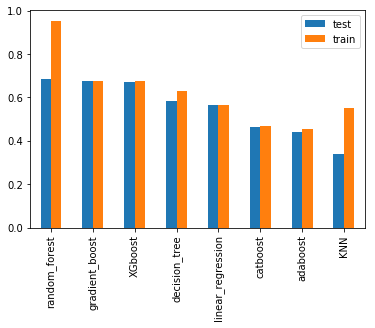

In [156]:
models_sfm.plot(kind='bar')

**One hot encode zipcodes**

In [200]:
top50_zipcode = (list(dict(ml_df_o.zipcode.value_counts().head(50)).keys()))

In [201]:
def fill_zipcode(code):
    if code in top50_zipcode:
        return code
    else:
        return 'other'

In [202]:
ml_df_zipcode = ml_df_o.copy(deep=True)
ml_df_zipcode.zipcode = ml_df_zipcode.zipcode.apply(fill_zipcode)

In [203]:
zipcode_onehot_features = pd.get_dummies(ml_df_zipcode['zipcode'])

ml_df_zipcode = pd.concat([ml_df_zipcode, zipcode_onehot_features], axis=1)

ml_df_zipcode = ml_df_zipcode.drop('zipcode', axis=1)

In [204]:
ml_df_zipcode_noprice = ml_df_zipcode.drop('price', axis=1)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
ml_df_zipcode_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_zipcode_noprice.columns.values]

X_train, X_test, y_train, y_test = split_data(ml_df_zipcode_noprice, ml_df_zipcode.price)


In [205]:
model_scores_zipcode = run_models(X_train, X_test, y_train, y_test)

In [147]:
model_scores_zipcode = pd.DataFrame(model_scores_zipcode)
model_scores_zipcode = model_scores_zipcode.T
model_scores_zipcode

,test,train
linear_regression,0.643291,0.653536
decision_tree,0.518790,0.535276
random_forest,0.672496,0.951856
gradient_boost,0.674329,0.679570
adaboost,0.405747,0.417486
KNN,0.251398,0.487492
XGboost,0.675706,0.680023
catboost,0.471632,0.479060


In [153]:
model_scores_zipcode.sort_values(['test'], ascending=False, inplace=True)

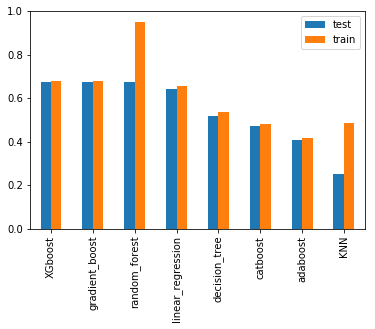

In [154]:
model_scores_zipcode.plot(kind='bar', sort_columns=True)

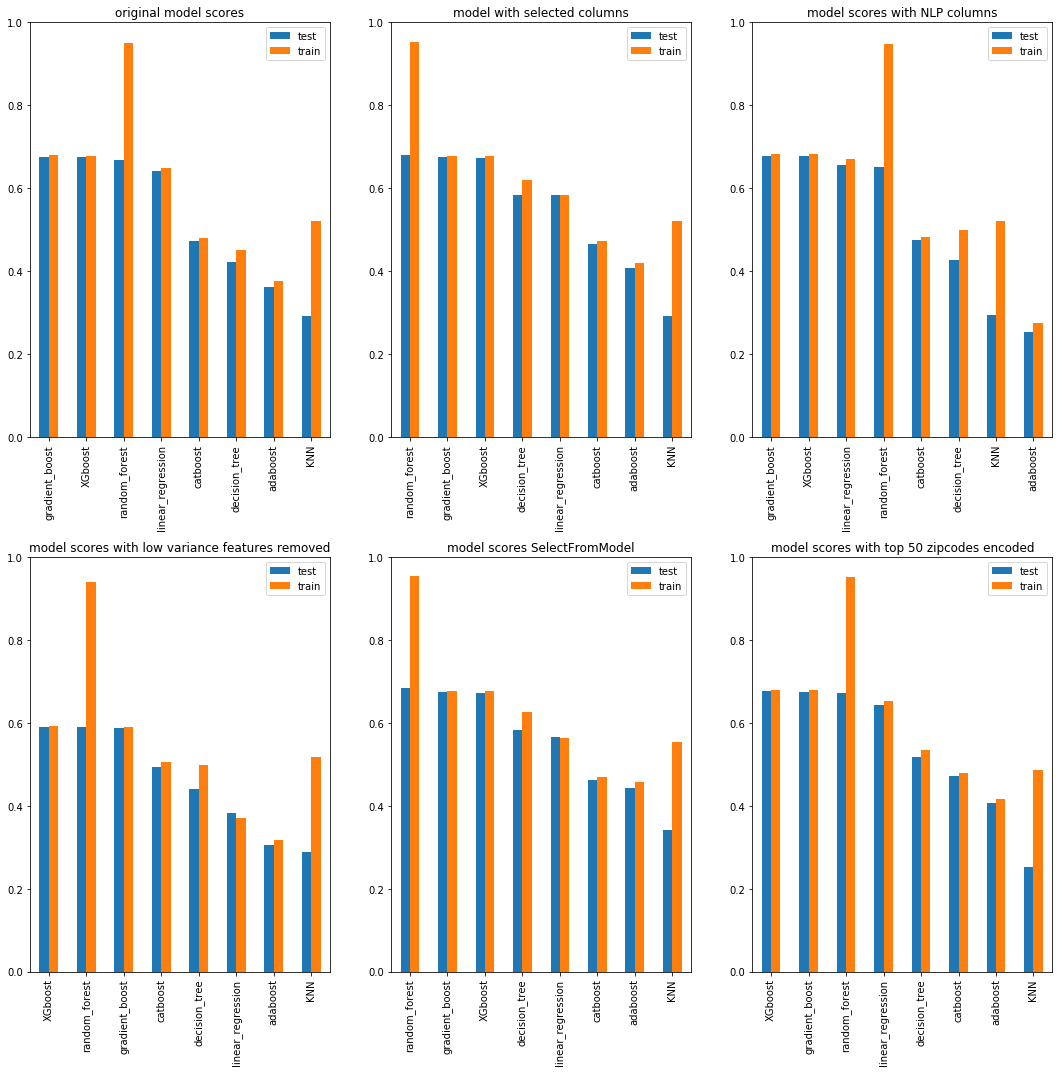

In [167]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

models.plot(kind='bar', ax=ax1)
ax1.set_title('original model scores')
ax1.set_ylim(0,1)

models_less.plot(kind='bar', ax=ax2)
ax2.set_title('model with selected columns')
ax2.set_ylim(0,1)

models_nlp.plot(kind='bar', ax=ax3)
ax3.set_title('model scores with NLP columns')
ax3.set_ylim(0,1)

models_low_variance.plot(kind='bar', ax=ax4)
ax4.set_title('model scores with low variance features removed')
ax4.set_ylim(0,1)

models_sfm.plot(kind='bar', ax=ax5)
ax5.set_title('model scores SelectFromModel')
ax5.set_ylim(0,1)

model_scores_zipcode.plot(kind='bar', ax=ax6)
ax6.set_title('model scores with top 50 zipcodes encoded')
ax6.set_ylim(0,1)
plt.tight_layout()


**The top 3 performing models are : XGboost, random forest and gradient boosting. Random forest seems to be over fitting in most cases. But we can continue with these models and try and increase the score by chaanging hyperparameters.**

In [168]:
model_score_dict = [models, models_less, models_nlp, models_low_variance, models_sfm, model_scores_zipcode]

In [196]:
random_forest={}
XGboost={}
gradient_boost={}
models = {0:'original model', 1:'model with fewer features', 2:'model with NLP features', 
         3:'model with low variance features removed', 4:'models with SelectFromModel features', 
         5:'model with zipcode encoded'}

for index, model in enumerate(model_score_dict):
    random_forest[index] = model.loc['random_forest','test']
    XGboost[index] = model.loc['XGboost','test']
    gradient_boost[index] = model.loc['gradient_boost','test']

print('Highest performing random forest model is : ', models[max(random_forest, key=random_forest.get)])
print('Highest performing XGboost model is : ', models[max(XGboost, key=XGboost.get)])
print('Highest performing gradient boosting model is : ', models[max(gradient_boost, key=gradient_boost.get)])

Highest performing random forest model is :  models with SelectFromModel features
Highest performing XGboost model is :  model with NLP features
Highest performing gradient boosting model is :  model with NLP features


**Random Forest**

In [206]:
X = ml_df_o_noprice
y = ml_df_o.price

model = GradientBoostingRegressor()

sfm = SelectFromModel(model, max_features=150)
X_new = sfm.fit_transform(X,y)

X_train, X_test, y_train, y_test = split_data(X_new, y)

random_forest_reg = RandomForestRegressor(n_estimators=50, max_features='sqrt')
random_forest_reg.fit(X_train, y_train)

print('Parameters currently in use:\n', random_forest_reg.get_params())
print('train', random_forest_reg.score(X_train, y_train), 'test',random_forest_reg.score(X_test, y_test))


Parameters currently in use:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
train 0.9530591394338453 test 0.6865784050244245


In [209]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [50,100,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [25,50,75,100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [50, 100, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [25, 50, 75, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3]}


In [210]:
rfr_random = RandomizedSearchCV(estimator=random_forest_reg, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=6, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rfr_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [25, 50, 75, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=6, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=2)

In [211]:
rfr_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 50}

In [214]:
rf = RandomForestRegressor(n_estimators=150, min_samples_split=2,min_samples_leaf=3,max_features='auto', max_depth=50)


In [215]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [216]:
rf.score(X_test, y_test)

0.6857800886176582

In [222]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'max_depth': [40, 50, 60],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [2,3],
    'n_estimators': [150, 200, 250],
    'max_depth': [50]}

# Create a base model
rf = RandomForestRegressor(random_state = 6)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [223]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=6, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [50], 'max_features': ['auto'], 'min_samples_leaf': [3, 4], 'min_samples_split': [2, 3], 'n_estimators': [150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [224]:
grid_search.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 250}

In [225]:
param_grid = {'max_depth': [45, 50, 55],
    'max_features': ['auto'],
    'min_samples_leaf': [3],
    'min_samples_split': [2],
    'n_estimators': [200, 500, 1000],
    'max_depth': [50]}

# Create a base model
rf = RandomForestRegressor(random_state = 6)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  4.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  5.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=6, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [50], 'max_features': ['auto'], 'min_samples_leaf': [3], 'min_samples_split': [2], 'n_estimators': [200, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [226]:
grid_search.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [227]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=2,min_samples_leaf=3,max_features='auto', max_depth=50)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [228]:
rf.score(X_test, y_test)

0.6875766185642811

******

In [10]:
ml_nlp_df_o_noprice = ml_nlp_df_o.drop('price', axis=1)

X_train, X_test, y_train, y_test = split_data(ml_nlp_df_o_noprice, ml_nlp_df_o.price)

In [11]:
model = GradientBoostingRegressor()
model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
from sklearn.metrics.regression import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope
import numpy as np

In [39]:
scope.define(GradientBoostingRegressor)    

def objective_function_regression(estimator):
    mse_array = cross_val_score( estimator, X_train, y_train, cv= 2, n_jobs=-1, scoring = make_scorer(mse) )
    return mse_array.mean()

In [53]:
# search space
n_estimators     = hp.randint('n_estimators',1000) 
#learning_rate    = hp.loguniform('learning_rate',-3,1)
#max_depth        = hp.randint('max_depth', 10)
#max_features     = hp.randint('max_features',X_train.shape[1])
#min_samples_leaf = hp.randint('min_samples_leaf', 10)

In [56]:
# model / estimator to be optimized
#est0 = (0.1, scope.GradientBoostingRegressor( loss = 'ls', alpha = 0.5, n_estimators  = n_estimators + 1,
#                                             learning_rate = learning_rate, max_depth = max_depth + 1,
#                                             max_features = max_features + 1, min_samples_leaf = min_samples_leaf + 1,
#                                             random_state= 6) )
#search_space_regression = hp.pchoice('estimator', [est0])

est0 = (0.1, scope.GradientBoostingRegressor( loss = 'ls', alpha = 0.5, n_estimators  = [500,1000],random_state= 6))
search_space_regression = hp.pchoice('estimator', [est0])



In [57]:
best = fmin(fn= objective_function_regression,space= search_space_regression, algo = tpe.suggest, max_evals = 3, 
           verbose=2)

  0%|          | 0/3 [00:00<?, ?it/s, best loss: ?]


TypeError: '<=' not supported between instances of 'tuple' and 'int'

In [ ]:
# Allocate optimized parameters and apply to test data set
Regressor = GradientBoostingRegressor( loss = loss, alpha = alpha, learning_rate = best['learning_rate'],
                                      max_depth = best['max_depth'], max_features = best['max_features'],
                                      min_samples_leaf = best['min_samples_leaf'], n_estimators = best['n_estimators'],
                                      random_state = 6)

In [ ]:
Regressor.fit(X_train,y_train)

In [ ]:
yhat = Regressor.predict(X_test) ;
error_pct = np.round( np.median(np.abs(yhat - y_test)), 2)

print("{} {}".format('The Median Abs. Error (%) for the test set is :', error_pct))

In [59]:
model=GradientBoostingRegressor()

In [65]:
from sklearn.model_selection import RandomizedSearchCV

In [60]:
param_grid = {'n_estimators': [500,1000]}


In [66]:
random_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2, return_train_score=True)

In [67]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 